In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.layers import Input
from keras.callbacks import EarlyStopping
# from keras.preprocessing import timeseries_dataset_from_array

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

In [2]:
rdf=pd.read_csv('output/DL_data.csv')

#### 데이터 전처리

In [3]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14831616 entries, 0 to 14831615
Data columns (total 23 columns):
 #   Column          Dtype  
---  ------          -----  
 0   year            int64  
 1   month           int64  
 2   day             int64  
 3   hour            int64  
 4   datetime        object 
 5   temp            float64
 6   rainfall        float64
 7   humidity        float64
 8   wind_speed      float64
 9   wind_direction  float64
 10  region          object 
 11  HI              float64
 12  DI              float64
 13  height          float64
 14  가로등             float64
 15  교육용             float64
 16  농사용             float64
 17  산업용             float64
 18  심야              float64
 19  일반용             float64
 20  임시전력            float64
 21  주택용             float64
 22  prev_winter     float64
dtypes: float64(17), int64(4), object(2)
memory usage: 2.5+ GB


In [4]:
# 전력데이터가 없는 2010-2012년 데이터 삭제
con1=rdf[(rdf['year'] == 2010) | (rdf['year'] == 2011) | (rdf['year'] == 2012)].index
rdf.drop(con1, axis=0, inplace=True)
rdf

,year,month,day,hour,datetime,temp,rainfall,humidity,wind_speed,wind_direction,...,height,가로등,교육용,농사용,산업용,심야,일반용,임시전력,주택용,prev_winter
22680,2013,1,1,0,2013-01-01 00:00:00,-6.9,0.0,76.0,0.9,90.0,...,42.48,4.12459,7.412881,NaN,3.166637,6.184731,62.336551,0.049086,16.725526,NaN
22681,2013,1,1,1,2013-01-01 01:00:00,-5.2,0.0,69.0,0.9,32.0,...,42.48,4.12459,7.412881,NaN,3.166637,6.184731,62.336551,0.049086,16.725526,NaN
22682,2013,1,1,2,2013-01-01 02:00:00,-3.0,0.0,62.0,0.6,240.0,...,42.48,4.12459,7.412881,NaN,3.166637,6.184731,62.336551,0.049086,16.725526,NaN
22683,2013,1,1,3,2013-01-01 03:00:00,-1.2,0.0,64.0,1.1,292.0,...,42.48,4.12459,7.412881,NaN,3.166637,6.184731,62.336551,0.049086,16.725526,NaN
22684,2013,1,1,4,2013-01-01 04:00:00,1.3,0.0,60.0,1.5,286.0,...,42.48,4.12459,7.412881,NaN,3.166637,6.184731,62.336551,0.049086,16.725526,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14831611,2022,4,30,19,2022-04-30 19:00:00,10.7,0.0,71.0,2.1,335.0,...,28.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14831612,2022,4,30,20,2022-04-30 20:00:00,11.0,0.0,65.0,2.2,339.0,...,28.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14831613,2022,4,30,21,2022-04-30 21:00:00,11.9,0.0,61.0,2.2,338.0,...,28.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14831614,2022,4,30,22,2022-04-30 22:00:00,13.4,0.0,53.0,2.0,351.0,...,28.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df=rdf[:]
print('Number of rows and columns:', df.shape)

fact = pd.factorize(df['region'])    # region 카테고리화
df['region'] = fact[0]    

#df.drop(['lightning','condition','datetime','HI','DI'], axis=1, inplace=True)

#df.dropna(inplace=True)

df['date'] = pd.to_datetime((df['year']*10000 + df['month']*100 + df['day']).astype(str), format='%Y%m%d') # date 컬럼 생성

# df.drop(['year','month','day'],axis=1,inplace=True)

#df=df[['date','month','temp','rainfall','humidity','wind_speed','wind_direction','region','hour']]
# df=df[['date','temp','rainfall','humidity','wind_speed','wind_direction','region','hour']]


# 필요한 데이터 추출
df=df[['year', 'month', 'day', 'hour', 'date', 'temp', 'region', 'humidity', 'wind_speed', 'wind_direction', 'HI', 'DI',
       '교육용', '산업용', '일반용', '임시전력', '주택용', 'prev_winter']]

df=df.reset_index(drop=True)
df

Number of rows and columns: (11611056, 23)


,year,month,day,hour,date,temp,region,humidity,wind_speed,wind_direction,HI,DI,교육용,산업용,일반용,임시전력,주택용,prev_winter
0,2013,1,1,0,2013-01-01,-6.9,0,76.0,0.9,90.0,-6.900000,24.65144,7.412881,3.166637,62.336551,0.049086,16.725526,NaN
1,2013,1,1,1,2013-01-01,-5.2,0,69.0,0.9,32.0,-5.200000,28.66888,7.412881,3.166637,62.336551,0.049086,16.725526,NaN
2,2013,1,1,2,2013-01-01,-3.0,0,62.0,0.6,240.0,-3.000000,33.16260,7.412881,3.166637,62.336551,0.049086,16.725526,NaN
3,2013,1,1,3,2013-01-01,-1.2,0,64.0,1.1,292.0,-1.200000,35.41568,7.412881,3.166637,62.336551,0.049086,16.725526,NaN
4,2013,1,1,4,2013-01-01,1.3,0,60.0,1.5,286.0,1.300000,39.54520,7.412881,3.166637,62.336551,0.049086,16.725526,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611051,2022,4,30,19,2022-04-30,10.7,141,71.0,2.1,335.0,9.679444,52.33503,NaN,NaN,NaN,NaN,NaN,NaN
11611052,2022,4,30,20,2022-04-30,11.0,141,65.0,2.2,339.0,9.852778,52.99350,NaN,NaN,NaN,NaN,NaN,NaN
11611053,2022,4,30,21,2022-04-30,11.9,141,61.0,2.2,338.0,10.738333,54.40241,NaN,NaN,NaN,NaN,NaN,NaN
11611054,2022,4,30,22,2022-04-30,13.4,141,53.0,2.0,351.0,12.179444,56.60598,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df=df.fillna(0)
df

,year,month,day,hour,date,temp,region,humidity,wind_speed,wind_direction,HI,DI,교육용,산업용,일반용,임시전력,주택용,prev_winter
0,2013,1,1,0,2013-01-01,-6.9,0,76.0,0.9,90.0,-6.900000,24.65144,7.412881,3.166637,62.336551,0.049086,16.725526,0.0
1,2013,1,1,1,2013-01-01,-5.2,0,69.0,0.9,32.0,-5.200000,28.66888,7.412881,3.166637,62.336551,0.049086,16.725526,0.0
2,2013,1,1,2,2013-01-01,-3.0,0,62.0,0.6,240.0,-3.000000,33.16260,7.412881,3.166637,62.336551,0.049086,16.725526,0.0
3,2013,1,1,3,2013-01-01,-1.2,0,64.0,1.1,292.0,-1.200000,35.41568,7.412881,3.166637,62.336551,0.049086,16.725526,0.0
4,2013,1,1,4,2013-01-01,1.3,0,60.0,1.5,286.0,1.300000,39.54520,7.412881,3.166637,62.336551,0.049086,16.725526,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611051,2022,4,30,19,2022-04-30,10.7,141,71.0,2.1,335.0,9.679444,52.33503,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
11611052,2022,4,30,20,2022-04-30,11.0,141,65.0,2.2,339.0,9.852778,52.99350,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
11611053,2022,4,30,21,2022-04-30,11.9,141,61.0,2.2,338.0,10.738333,54.40241,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
11611054,2022,4,30,22,2022-04-30,13.4,141,53.0,2.0,351.0,12.179444,56.60598,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [8]:
# plt.figure(figsize=(20, 7))
# sns.lineplot(x='date', y='temp', data=df)

In [9]:
# corr=df.corr()
# corr

In [10]:
# plt.rcParams['font.family'] = 'Malgun Gothic'
# sns.heatmap(corr, cmap='YlGnBu')

In [7]:
# 6, 7, 8, 9월 데이터만 추출
df=df[(df['month']==6)|(df['month']==7)|(df['month']==8)|(df['month']==9)]

In [12]:
# # 2019, 2020, 2021, 2022년도 데이터만 추출
# df=df[(df['year']==2019)|(df['year']==2020)|(df['year']==2021)|(df['year']==2022)]
# df

,year,month,day,hour,date,temp,region,humidity,wind_speed,wind_direction,HI,DI,교육용,산업용,일반용,임시전력,주택용,prev_winter
56208,2019,6,1,0,2019-06-01,21.3,동인동,43.0,2.9,286.0,20.608333,66.47141,0.000000,3.431701,69.911162,0.000000,21.215028,11.0
56209,2019,6,1,1,2019-06-01,22.3,동인동,40.0,2.3,297.0,21.630000,67.47380,0.000000,3.431701,69.911162,0.000000,21.215028,11.0
56210,2019,6,1,2,2019-06-01,24.7,동인동,33.0,2.1,283.0,24.087222,69.65749,0.000000,3.431701,69.911162,0.000000,21.215028,11.0
56211,2019,6,1,3,2019-06-01,24.5,동인동,31.0,2.8,303.0,23.815000,69.23105,0.000000,3.431701,69.911162,0.000000,21.215028,11.0
56212,2019,6,1,4,2019-06-01,25.6,동인동,28.0,3.2,293.0,24.946667,70.12832,0.000000,3.431701,69.911162,0.000000,21.215028,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11605963,2021,9,30,19,2021-09-30,16.8,구지면,100.0,0.5,338.0,17.146667,62.24000,0.210072,85.281232,5.811550,0.192053,6.479514,4428.0
11605964,2021,9,30,20,2021-09-30,17.1,구지면,100.0,1.0,328.0,17.476667,62.78000,0.210072,85.281232,5.811550,0.192053,6.479514,4428.0
11605965,2021,9,30,21,2021-09-30,16.9,구지면,100.0,2.0,346.0,17.256667,62.42000,0.210072,85.281232,5.811550,0.192053,6.479514,4428.0
11605966,2021,9,30,22,2021-09-30,17.5,구지면,100.0,2.2,325.0,17.916667,63.50000,0.210072,85.281232,5.811550,0.192053,6.479514,4428.0


### One-hot-encoding

In [12]:
# region : one-hot-encoding
#df=pd.get_dummies(df, columns=['region'], drop_first=True) # 열을 n-1개 생성]
#df

,year,month,day,hour,date,temp,humidity,wind_speed,wind_direction,HI,DI,교육용,산업용,일반용,임시전력,주택용,prev_winter,region_감삼동,region_검단동,region_고산1동,region_고산2동,region_고산3동,region_고성동,region_공산동,region_관문동,region_관음동,region_구암동,region_구지면,region_국우동,region_남산1동,region_남산2동,region_남산3동,region_남산4동,region_내당1동,region_내당2.3동,region_내당4동,region_노원동,region_논공읍,region_다사읍,region_대명10동,...,region_옥포읍,region_용산1동,region_용산2동,region_원대동,region_월성1동,region_월성2동,region_유가읍,region_읍내동,region_이곡1동,region_이곡2동,region_이천동,region_장기동,region_죽전동,region_중동,region_지산1동,region_지산2동,region_지저동,region_진천동,region_칠성동,region_침산1동,region_침산2동,region_침산3동,region_태전1동,region_태전2동,region_파동,region_평리1동,region_평리2동,region_평리3동,region_평리4동,region_평리5동,region_평리6동,region_하빈면,region_해안동,region_혁신동,region_현풍읍,region_화원읍,region_황금1동,region_황금2동,region_효목1동,region_효목2동
3624,2013,6,1,0,2013-06-01,20.1,66.0,0.9,96.0,19.888889,66.27634,8.427410,2.516595,64.74751,0.000000,17.840628,4014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3625,2013,6,1,1,2013-06-01,21.6,58.0,0.8,321.0,21.330000,67.90472,8.427410,2.516595,64.74751,0.000000,17.840628,4014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3626,2013,6,1,2,2013-06-01,23.0,50.0,1.3,266.0,22.661111,69.16500,8.427410,2.516595,64.74751,0.000000,17.840628,4014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3627,2013,6,1,3,2013-06-01,24.2,50.0,2.1,302.0,23.981111,70.73100,8.427410,2.516595,64.74751,0.000000,17.840628,4014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3628,2013,6,1,4,2013-06-01,25.0,41.0,1.7,288.0,24.626111,70.83450,8.427410,2.516595,64.74751,0.000000,17.840628,4014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11605963,2021,9,30,19,2021-09-30,16.8,100.0,0.5,338.0,17.146667,62.24000,0.210072,85.281232,5.81155,0.192053,6.479514,4428.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11605964,2021,9,30,20,2021-09-30,17.1,100.0,1.0,328.0,17.476667,62.78000,0.210072,85.281232,5.81155,0.192053,6.479514,4428.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11605965,2021,9,30,21,2021-09-30,16.9,100.0,2.0,346.0,17.256667,62.42000,0.210072,85.281232,5.81155,0.192053,6.479514,4428.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11605966,2021,9,30,22,2021-09-30,17.5,100.0,2.2,325.0,17.916667,63.50000,0.210072,85.281232,5.81155,0.192053,6.479514,4428.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### train과 test로 데이터 분리

In [8]:
df[df['date']=='2021-06-01']

,year,month,day,hour,date,temp,region,humidity,wind_speed,wind_direction,HI,DI,교육용,산업용,일반용,임시전력,주택용,prev_winter
73752,2021,6,1,0,2021-06-01,23.6,0,53.0,1.4,117.0,23.399444,70.21992,7.837531,3.133206,65.06656,0.963212,20.014767,4428.0
73753,2021,6,1,1,2021-06-01,24.3,0,53.0,1.0,90.0,24.169444,71.15421,7.837531,3.133206,65.06656,0.963212,20.014767,4428.0
73754,2021,6,1,2,2021-06-01,25.4,0,49.0,1.2,202.0,25.275000,72.18854,7.837531,3.133206,65.06656,0.963212,20.014767,4428.0
73755,2021,6,1,3,2021-06-01,26.7,0,45.0,2.0,131.0,26.886497,73.38685,7.837531,3.133206,65.06656,0.963212,20.014767,4428.0
73756,2021,6,1,4,2021-06-01,27.8,0,43.0,2.2,323.0,27.693014,74.50346,7.837531,3.133206,65.06656,0.963212,20.014767,4428.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11603059,2021,6,1,19,2021-06-01,17.4,141,92.0,0.8,332.0,17.597778,63.08592,0.169344,86.183909,5.27669,0.267719,4.934515,4428.0
11603060,2021,6,1,20,2021-06-01,17.1,141,93.0,0.1,214.0,17.293889,62.59597,0.169344,86.183909,5.27669,0.267719,4.934515,4428.0
11603061,2021,6,1,21,2021-06-01,18.9,141,86.0,0.7,316.0,19.091111,65.40246,0.169344,86.183909,5.27669,0.267719,4.934515,4428.0
11603062,2021,6,1,22,2021-06-01,21.4,141,70.0,1.5,188.0,21.423333,68.45420,0.169344,86.183909,5.27669,0.267719,4.934515,4428.0


In [10]:
# Setting
train_split_idx=73752                 # 2020-01-01 0:0:0행 인덱스의 번호
window_size = 10000                  # 과거 10000시간 동안 시계열 데이터를 학습 데이터로 사용
future = 24                           # 24시간 이후의 타깃 예측

# Features
X_train=df.iloc[:train_split_idx-window_size-future,0:]
#X_train=X_train.drop('temp', axis=1)                        # temp를 제외한 나머지 변수

# Targets
y_train=df.iloc[window_size+future:train_split_idx,[5]]  # 'temp' 열

print(X_train.shape,y_train.shape)

(63728, 18) (63728, 1)


In [11]:
# X_test
test_start=train_split_idx-window_size-future   # 테스트 데이터 시작 행
test_end=df.shape[0]-window_size-future
X_test=df.iloc[test_start:test_end,0:]

# y_test
# label_start= +future        # 테스트 데이터의 첫 번째 타깃 데이터 위치
y_test=df.iloc[train_split_idx:,[5]]    # 'temp' 열 선택

print(X_test.shape,y_test.shape)

(3668232, 18) (3668232, 1)


#### 입력 데이터 0~1로 조정

In [12]:
# Feature Scaling
scaler=MinMaxScaler()
X_train_scaled=X_train.loc[:, 'humidity':]
X_test_scaled=X_test.loc[:, 'humidity':]
scaler.fit_transform(X_train_scaled.values)
X_train_scaled=scaler.transform(X_train_scaled.values)
X_test_scaled=scaler.transform(X_test_scaled.values)
#df_scaled=pd.DataFrame(df_scaled, columns=cols)
#f_scaled

In [13]:
X_test_scaled

array([[0.9       , 0.09655172, 0.27423823, ..., 0.        , 0.        ,
        0.33291179],
       [0.91111111, 0.10344828, 0.22160665, ..., 0.        , 0.        ,
        0.33291179],
       [0.91111111, 0.11724138, 0.29916898, ..., 0.        , 0.        ,
        0.33291179],
       ...,
       [0.61111111, 0.1862069 , 0.04709141, ..., 0.3405474 , 0.20941568,
        1.        ],
       [0.63333333, 0.19310345, 0.04155125, ..., 0.3405474 , 0.20941568,
        1.        ],
       [0.7       , 0.13793103, 0.81440443, ..., 0.3405474 , 0.20941568,
        1.        ]])

In [14]:
X_train_scaled

array([[0.62222222, 0.06206897, 0.26869806, ..., 0.        , 0.67715845,
        0.42301612],
       [0.53333333, 0.05517241, 0.89196676, ..., 0.        , 0.67715845,
        0.42301612],
       [0.44444444, 0.08965517, 0.73961219, ..., 0.        , 0.67715845,
        0.42301612],
       ...,
       [0.91111111, 0.11034483, 0.27146814, ..., 0.        , 0.        ,
        0.33291179],
       [0.9       , 0.07586207, 0.34626039, ..., 0.        , 0.        ,
        0.33291179],
       [0.88888889, 0.15862069, 0.27977839, ..., 0.        , 0.        ,
        0.33291179]])

In [15]:
# Mini Batch 크기로 시계열 변환
train_data=timeseries_dataset_from_array(X_train_scaled,y_train,sequence_length=window_size)
test_data=timeseries_dataset_from_array(X_test_scaled,y_test,sequence_length=window_size)

print(train_data)
print(test_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 11), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, None, 11), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [16]:
for batch in test_data.take(1):
    inputs,targets=batch

print("Input:",inputs.numpy().shape)
print("Target:",targets.numpy().shape)

Input: (128, 10000, 11)
Target: (128, 1)


In [22]:
model=Sequential()
model.add(Input(shape=[1000, 152]))

model.add(LSTM(units=32,return_sequences=False))
model.add(Dense(units=16,activation='linear'))
model.add(Dense(units=1,activation='linear'))

model.compile(optimizer='adam',loss='mae',metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                23680     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,225
Trainable params: 24,225
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 모델 훈련
history=model.fit(train_data,epochs=10,validation_data=test_data,verbose=1, batch_size=128)

# 손실 함수 그래프
def plot_loss_curve(history,total_epoch=10,start=1):
    plt.figure(figsize=(5,5))
    plt.plot(range(start,total_epoch+1),
        history.history['loss'][start-1:total_epoch],
        label='Train')
    plt.plot(range(start,total_epoch+1),
        history.history['val_loss'][start-1:total_epoch],
        label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

plot_loss_curve(history=history,total_epoch=len(history.history['loss']),start=1)

NameError: name 'model' is not defined

In [24]:
y_pred=model.predict(test_data)
y_pred.shape

9230/9230 [==============================] - 3491s 378ms/step


(1181337, 1)

In [29]:
loss, acc = model.evaluate(inputs, targets, batch_size=16)

TypeError: 'NoneType' object is not callable

In [30]:
print("\n테스트 데이터의 Accuracy 값: ", acc)
for i in range(5):
    print("%d 번째 테스트 데이터의 실제값: %d" % (i, y_test.iloc[i]))
    print("%d 번째 테스트 데이터의 예측값: %d" % (i, np.argmax(y_pred[i])))

NameError: name 'acc' is not defined

In [28]:
model.evaluate(inputs, targets)

KeyboardInterrupt: 

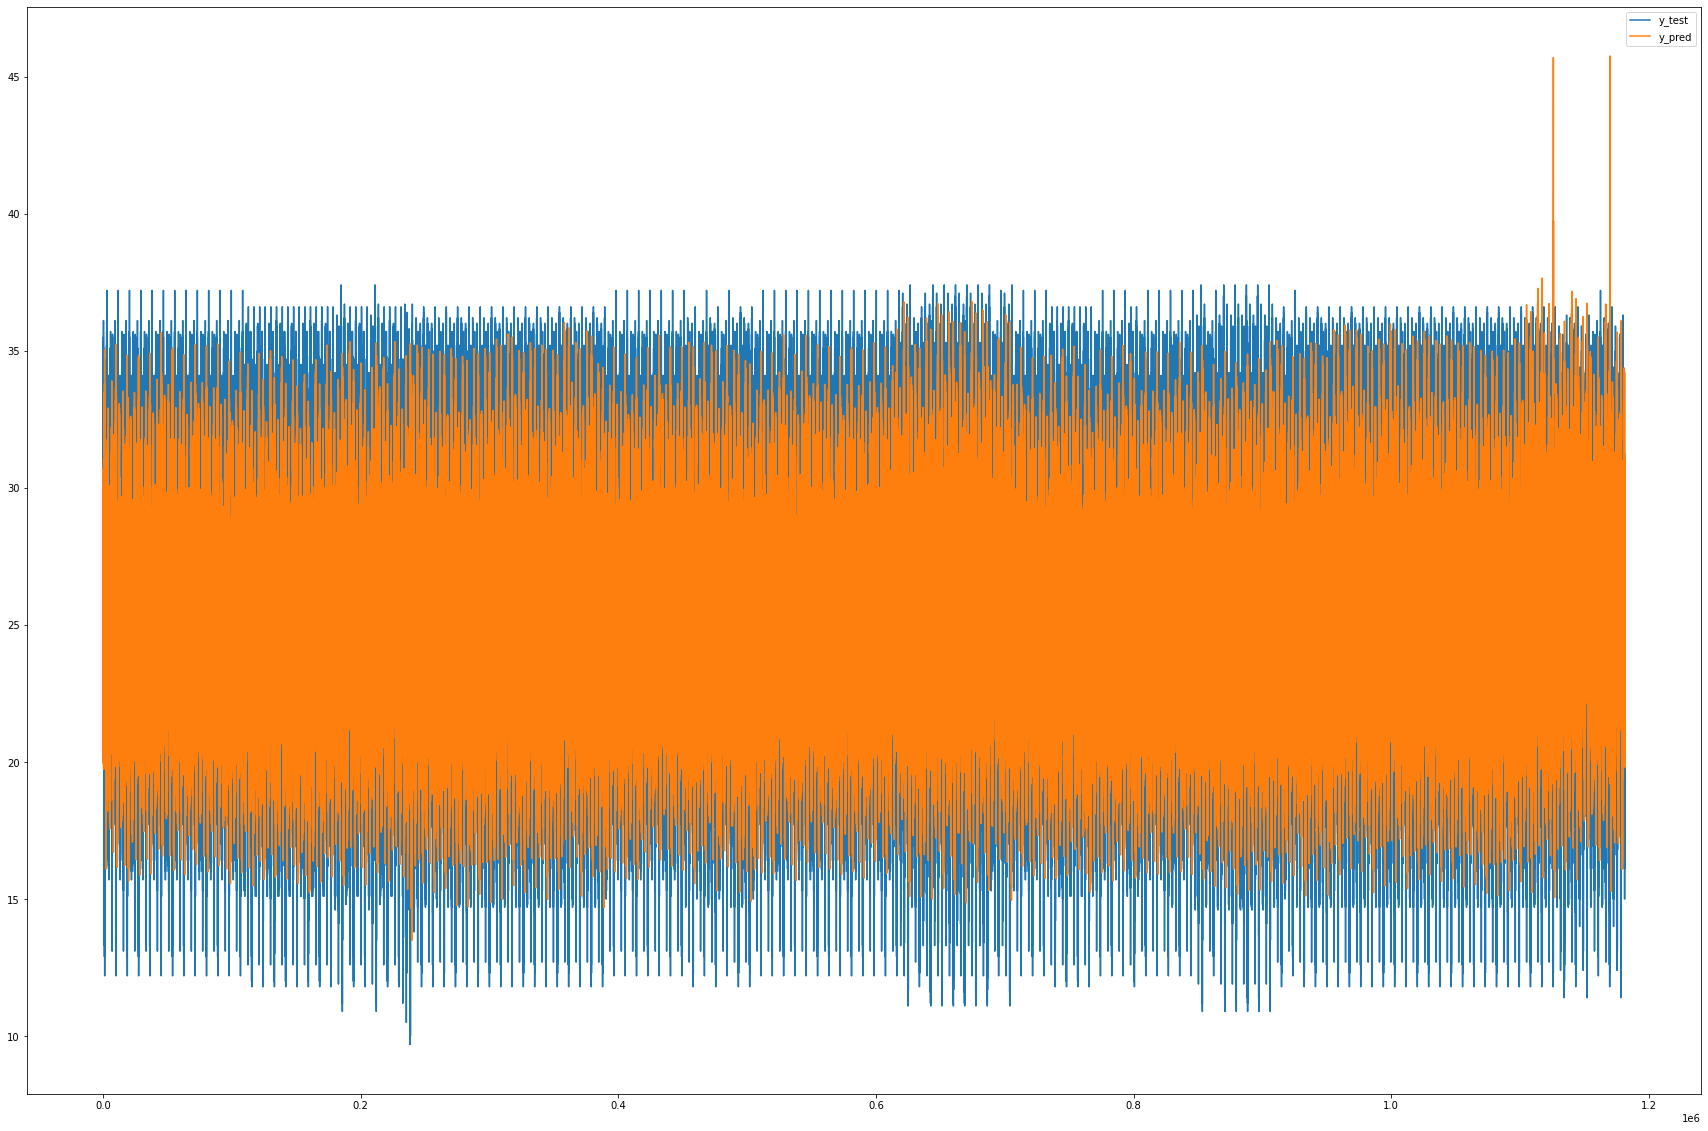

In [41]:
plt.figure(figsize=(30, 20))
plt.plot(range(len(y_pred)), y_test[window_size-1:], label='y_test')
plt.plot(range(len(y_pred)), y_pred, label='y_pred')
plt.legend()
plt.show()

전체 데이터

In [17]:
for batch in test_data.take(1):
    inputs,targets=batch

print("Input:",inputs.numpy().shape)
print("Target:",targets.numpy().shape)

Input: (128, 1000, 152)
Target: (128, 1)


In [21]:
model=Sequential()
model.add(Input(shape=[1000, 152]))

model.add(LSTM(units=32,return_sequences=False))
model.add(Dense(units=16,activation='linear'))
model.add(Dense(units=1,activation='linear'))

model.compile(optimizer='adam',loss='mae',metrics=['mse'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                23680     
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,225
Trainable params: 24,225
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 모델 훈련
history=model.fit(train_data,epochs=10,validation_data=test_data,verbose=1, batch_size=128)
model.save('output/model1.h5') # 모델 전체 저장
# model.save_weights('output/check_point') # 가중치저장

# 손실 함수 그래프
def plot_loss_curve(history,total_epoch=10,start=1):
    plt.figure(figsize=(5,5))
    plt.plot(range(start,total_epoch+1),
        history.history['loss'][start-1:total_epoch],
        label='Train')
    plt.plot(range(start,total_epoch+1),
        history.history['val_loss'][start-1:total_epoch],
        label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

plot_loss_curve(history=history,total_epoch=len(history.history['loss']),start=1)

Epoch 1/10
561/561 [==============================] - 10697s 19s/step - loss: 5.5265 - mse: 64.3720 - val_loss: 4.2479 - val_mse: 29.5026
Epoch 2/10
561/561 [==============================] - 10811s 19s/step - loss: 3.7655 - mse: 21.6151 - val_loss: 4.1607 - val_mse: 28.2593
Epoch 3/10
561/561 [==============================] - ETA: 0s - loss: 3.6301 - mse: 20.1386

KeyboardInterrupt: 

In [23]:
model.save('output/model1.h5')

In [32]:
loss_and_metrics = model.evaluate(X_test_scaled, y_test, batch_size=128)
loss_and_metrics

TypeError: 'NoneType' object is not callable

In [ ]:
yhat = model.predict(test_data)
print('## yhat ##')
print(yhat)

9230/9230 [==============================] - 3491s 378ms/step


(1181337, 1)

In [ ]:
print("\n테스트 데이터의 Accuracy 값: ", acc)
for i in range(5):
    print("%d 번째 테스트 데이터의 실제값: %d" % (i, test_Y.iloc[i]))
    print("%d 번째 테스트 데이터의 예측값: %d" % (i, np.argmax(predictions[i])))

In [18]:
plt.figure(figsize=(30, 20))
plt.plot(range(len(y_pred)), y_test[window_size-1:], label='y_test')
plt.plot(range(len(y_pred)), y_pred, label='y_pred')
plt.legend()
plt.show()

NameError: name 'y_pred' is not defined

<Figure size 2160x1440 with 0 Axes>

In [ ]:
# 저장된 모델
from tensorflow.keras.models import load_model
model = load_model('output/model1.h5')

# 전체기간, 전체 지역 배치 늘리기

In [33]:
model=Sequential()
model.add(Input(shape=[1000, 152]))

model.add(LSTM(units=32,return_sequences=False))
model.add(Dense(units=16,activation='linear'))
model.add(Dense(units=1,activation='linear'))

model.compile(optimizer='adam',loss='mae',metrics=['mse'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                23680     
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,225
Trainable params: 24,225
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 모델 훈련
history=model.fit(train_data,epochs=15, validation_data=test_data, verbose=1, batch_size=256,
                         callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='./model/origmodel.h5', save_best_only=True, verbose=1)])
model.save('output/model1.h5') # 모델 전체 저장
# model.save_weights('output/check_point') # 가중치저장

# 손실 함수 그래프
def plot_loss_curve(history,total_epoch=10,start=1):
    plt.figure(figsize=(5,5))
    plt.plot(range(start,total_epoch+1),
        history.history['loss'][start-1:total_epoch],
        label='Train')
    plt.plot(range(start,total_epoch+1),
        history.history['val_loss'][start-1:total_epoch],
        label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

plot_loss_curve(history=history,total_epoch=len(history.history['loss']),start=1)

Epoch 1/15
561/561 [==============================] - ETA: 0s - loss: 5.1536 - mse: 55.0059
Epoch 1: val_loss improved from inf to 3.74241, saving model to ./model\origmodel.h5
561/561 [==============================] - 10889s 19s/step - loss: 5.1536 - mse: 55.0059 - val_loss: 3.7424 - val_mse: 21.3569
Epoch 2/15
561/561 [==============================] - ETA: 0s - loss: 3.7351 - mse: 21.2920

KeyboardInterrupt: 

In [21]:
# 최종 모델 복원, 요약
loaded_model = tf.keras.models.load_model('./model/origmodel.h5')
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                23680     
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,225
Trainable params: 24,225
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 모델 재훈련
history=loaded_model.fit(train_data,epochs=15,validation_data=test_data,verbose=1,callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='./model/origmodel.h5', save_best_only=True, verbose=1)])
# 최종 모델 저장
history.save('./model/model2nd.h5')

# 손실 함수 그래프
def plot_loss_curve(history,total_epoch=50,start=1):
    plt.figure(figsize=(5,5))
    plt.plot(range(start,total_epoch+1),
        history.history['loss'][start-1:total_epoch],
        label='Train')
    plt.plot(range(start,total_epoch+1),
        history.history['val_loss'][start-1:total_epoch],
        label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

plot_loss_curve(history=history,total_epoch=len(history.history['loss']),start=1)

Epoch 1/15


ValueError: in user code:

    File "c:\final_project\Team_Project\.venv\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\final_project\Team_Project\.venv\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\final_project\Team_Project\.venv\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\final_project\Team_Project\.venv\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\final_project\Team_Project\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\final_project\Team_Project\.venv\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 1000, 152), found shape=(None, None, 11)


In [ ]:
loss_and_metrics = model.evaluate(inputs, targets, batch_size=256)
loss_and_metrics

NameError: name 'model' is not defined

In [ ]:
yhat = model.predict(test_data)
print('## yhat ##')
print(yhat)

9230/9230 [==============================] - 3491s 378ms/step


(1181337, 1)

In [ ]:
print("\n테스트 데이터의 Accuracy 값: ", acc)
for i in range(5):
    print("%d 번째 테스트 데이터의 실제값: %d" % (i, y_test.iloc[i]))
    print("%d 번째 테스트 데이터의 예측값: %d" % (i, np.argmax(yhat[i])))

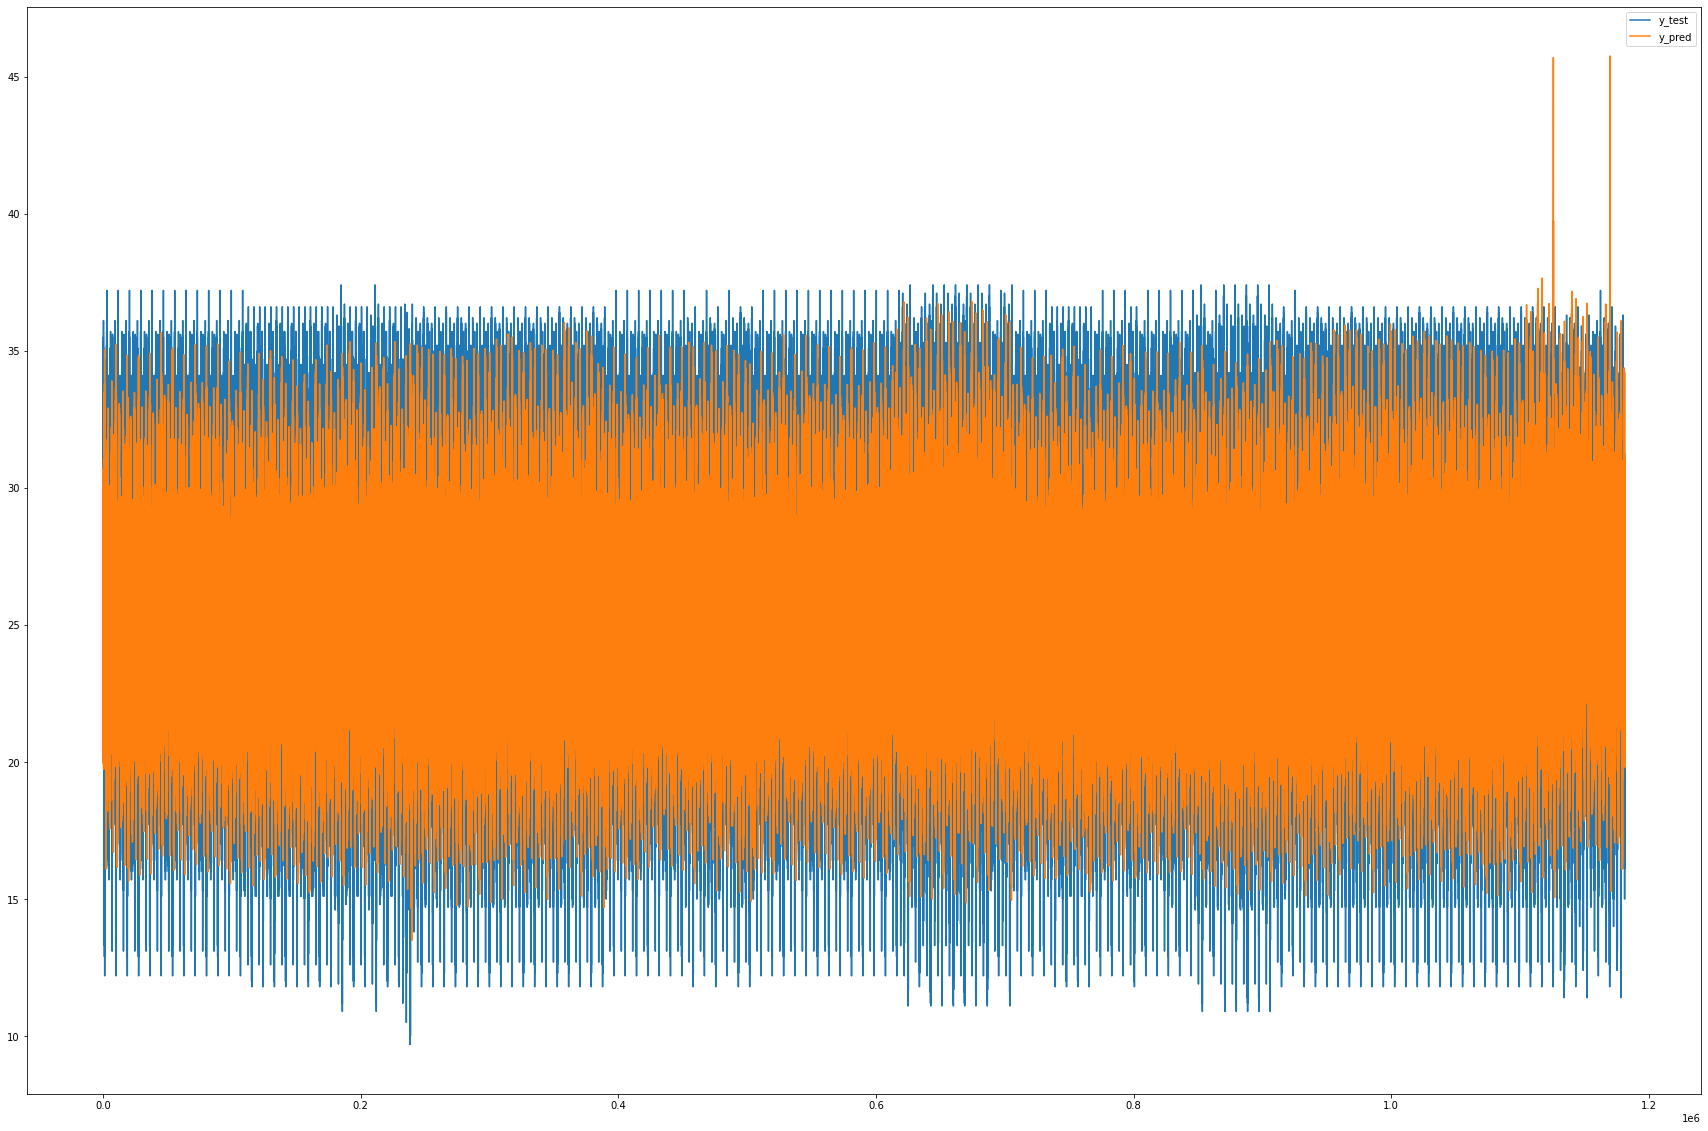

In [ ]:
plt.figure(figsize=(30, 20))
plt.plot(range(len(yhat)), y_test[window_size-1:], label='y_test')
plt.plot(range(len(yhat)), yhat, label='y_pred')
plt.legend()
plt.show()

In [23]:
model=Sequential()
model.add(Input(shape=[1000, 152]))

model.add(LSTM(units=32,return_sequences=False))
model.add(Dense(units=16,activation='linear'))
model.add(Dense(units=1,activation='linear'))

model.compile(optimizer='adam',loss='mae',metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                23680     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,225
Trainable params: 24,225
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 모델 훈련
history=model.fit(train_data,epochs=15, validation_data=test_data, verbose=1, batch_size=512,
                         callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='./model/origmodel.h5', save_best_only=True, verbose=1)])
model.save('output/model1.h5') # 모델 전체 저장
# model.save_weights('output/check_point') # 가중치저장

# 손실 함수 그래프
def plot_loss_curve(history,total_epoch=10,start=1):
    plt.figure(figsize=(5,5))
    plt.plot(range(start,total_epoch+1),
        history.history['loss'][start-1:total_epoch],
        label='Train')
    plt.plot(range(start,total_epoch+1),
        history.history['val_loss'][start-1:total_epoch],
        label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

plot_loss_curve(history=history,total_epoch=len(history.history['loss']),start=1)

Epoch 1/15
561/561 [==============================] - ETA: 0s - loss: 5.2724 - mse: 58.1964
Epoch 1: val_loss improved from inf to 4.79502, saving model to ./model\origmodel.h5
561/561 [==============================] - 10987s 20s/step - loss: 5.2724 - mse: 58.1964 - val_loss: 4.7950 - val_mse: 41.0144
Epoch 2/15
561/561 [==============================] - ETA: 0s - loss: 3.7142 - mse: 21.0846
Epoch 2: val_loss improved from 4.79502 to 4.63080, saving model to ./model\origmodel.h5
561/561 [==============================] - 10731s 19s/step - loss: 3.7142 - mse: 21.0846 - val_loss: 4.6308 - val_mse: 38.4158
Epoch 3/15
561/561 [==============================] - ETA: 0s - loss: 3.4286 - mse: 18.0197

KeyboardInterrupt: 

In [42]:
model=Sequential()
model.add(Input(shape=[1000, 11]))

model.add(LSTM(units=32,return_sequences=False))
model.add(Dense(units=16,activation='linear'))
model.add(Dense(units=1,activation='linear'))

model.compile(optimizer='adam',loss='mae',metrics=['mse'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                5632      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,177
Trainable params: 6,177
Non-trainable params: 0
_________________________________________________________________


In [43]:
# 모델 훈련
history=model.fit(train_data,epochs=10,validation_data=test_data,verbose=1, batch_size=1024)
model.save('./model/20220610_model.h5') # 모델 전체 저장
# model.save_weights('output/check_point') # 가중치저장

# 손실 함수 그래프
def plot_loss_curve(history,total_epoch=10,start=1):
    plt.figure(figsize=(5,5))
    plt.plot(range(start,total_epoch+1),
        history.history['loss'][start-1:total_epoch],
        label='Train')
    plt.plot(range(start,total_epoch+1),
        history.history['val_loss'][start-1:total_epoch],
        label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

plot_loss_curve(history=history,total_epoch=len(history.history['loss']),start=1)

Epoch 1/10
561/561 [==============================] - 5270s 9s/step - loss: 5.8593 - mse: 72.8460 - val_loss: 3.8044 - val_mse: 22.2059
Epoch 2/10
561/561 [==============================] - 5488s 10s/step - loss: 3.7502 - mse: 21.4912 - val_loss: 3.9313 - val_mse: 24.5596
Epoch 3/10
561/561 [==============================] - 5380s 10s/step - loss: 3.5323 - mse: 19.1681 - val_loss: 4.4031 - val_mse: 35.7881
Epoch 4/10
561/561 [==============================] - ETA: 0s - loss: 3.0093 - mse: 14.0525

KeyboardInterrupt: 

2022.06.13

In [19]:
model=Sequential()
model.add(Input(shape=[10000, 11]))

model.add(LSTM(units=32,return_sequences=False))
model.add(Dense(units=16,activation='linear'))
model.add(Dense(units=1,activation='linear'))

model.compile(optimizer='adam',loss='mae',metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5632      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,177
Trainable params: 6,177
Non-trainable params: 0
_________________________________________________________________


In [20]:
# 모델 훈련
history=model.fit(train_data,epochs=10,validation_data=test_data,verbose=1, batch_size=1024)
model.save('./model/20220610_model.h5') # 모델 전체 저장
# model.save_weights('output/check_point') # 가중치저장

# 손실 함수 그래프
def plot_loss_curve(history,total_epoch=10,start=1):
    plt.figure(figsize=(5,5))
    plt.plot(range(start,total_epoch+1),
        history.history['loss'][start-1:total_epoch],
        label='Train')
    plt.plot(range(start,total_epoch+1),
        history.history['val_loss'][start-1:total_epoch],
        label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

plot_loss_curve(history=history,total_epoch=len(history.history['loss']),start=1)

Epoch 1/10
420/420 [==============================] - ETA: 0s - loss: 5.7150 - mse: 70.5936

KeyboardInterrupt: 